In [1]:
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import getpass  # To get the password without showing the input
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import seaborn as sns

#%matplotlib inline
password = getpass.getpass()
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)

········


# Connect with SQL

In [2]:
query = '''SELECT rental_id,category_id, special_features, title, rental_date, rental_duration, return_date, COUNT(rental_id) OVER (Partition by customer_id) popularity_score
FROM rental r
JOIN inventory i
USING(inventory_id)
JOIN film f
USING(film_id)
JOIN film_category
USING(film_id)
ORDER BY return_date DESC;'''

data = pd.read_sql_query(query, engine)
data.head()

,rental_id,category_id,special_features,title,rental_date,rental_duration,return_date,popularity_score
0,16005,15,Behind the Scenes,RECORDS ZORRO,2005-08-23 21:00:22,7,2005-09-02 02:35:22,23
1,16040,7,"Commentaries,Deleted Scenes",SCORPION APOLLO,2005-08-23 22:19:33,3,2005-09-02 02:19:33,19
2,15971,7,Deleted Scenes,SAINTS BRIDE,2005-08-23 19:59:33,5,2005-09-02 01:28:33,28
3,15928,9,"Commentaries,Behind the Scenes",ILLUSION AMELIE,2005-08-23 18:23:24,4,2005-09-01 23:43:24,41
4,15922,3,"Deleted Scenes,Behind the Scenes",GORGEOUS BINGO,2005-08-23 18:07:31,4,2005-09-01 22:27:31,29


*I thought that the category, special_features, rating, title, rental_duration, and the number of the times that a movies has been rented as a popularity_score can be important to show if a movie is more popular and more probable to be rented*

# Exploring Data: Analyze extracted features and transform them. You may need to encode some categorical variables, or scale numerical variables.

In [3]:
data['rental_date'].value_counts()

2006-02-14 15:16:03    182
2005-08-19 16:47:41      2
2005-07-27 08:14:34      2
2005-08-01 12:44:17      2
2005-08-22 04:51:42      2
                      ... 
2005-07-31 08:56:08      1
2005-08-01 05:10:02      1
2005-08-02 06:52:54      1
2005-07-30 05:12:01      1
2005-08-21 00:30:32      1
Name: rental_date, Length: 15815, dtype: int64

In [4]:
data.sort_values(['popularity_score'], ascending = False)

,rental_id,category_id,special_features,title,rental_date,rental_duration,return_date,popularity_score
5397,9023,8,Deleted Scenes,OPPOSITE NECKLACE,2005-07-30 05:36:40,7,2005-08-07 06:20:40,46
9214,6169,8,"Trailers,Commentaries,Behind the Scenes",MUSIC BOONDOCK,2005-07-11 10:25:56,7,2005-07-19 07:18:56,46
1311,14965,8,"Trailers,Behind the Scenes",DINOSAUR SECRETARY,2005-08-22 06:45:53,7,2005-08-27 10:05:53,46
8974,6640,10,"Trailers,Commentaries,Behind the Scenes",NAME DETECTIVE,2005-07-12 10:27:19,5,2005-07-21 06:28:19,46
1581,12512,14,"Trailers,Behind the Scenes",SUN CONFESSIONS,2005-08-18 13:28:27,5,2005-08-26 19:08:27,46
...,...,...,...,...,...,...,...,...
12308,3732,1,"Commentaries,Behind the Scenes",AMERICAN CIRCUS,2005-07-06 11:33:37,3,2005-07-08 08:31:37,12
15051,224,13,"Trailers,Commentaries",VAMPIRE WHALE,2005-05-26 10:18:27,4,2005-06-04 06:59:27,12
13768,3337,6,Commentaries,DUFFEL APOCALYPSE,2005-06-21 10:24:35,5,2005-06-22 13:51:35,12
12858,2643,7,Commentaries,HOBBIT ALIEN,2005-06-19 09:39:27,5,2005-06-26 10:27:27,12


In [5]:
data['title'].value_counts() #Checking which movie has been rented the most

BUCKET BROTHERHOOD     34
ROCKETEER MOTHER       33
JUGGLER HARDLY         32
RIDGEMONT SUBMARINE    32
FORWARD TEMPLE         32
                       ..
BRAVEHEART HUMAN        5
MANNEQUIN WORST         5
TRAIN BUNCH             4
HARDLY ROBBERS          4
MIXED DOORS             4
Name: title, Length: 958, dtype: int64

*Movie BUCKET BROTHERHOOD has been rented more than others.*

In [6]:
data.shape #checking the number of rows and columns

(16044, 8)

In [7]:
data.info() #checking the type of the columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16044 entries, 0 to 16043
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   rental_id         16044 non-null  int64         
 1   category_id       16044 non-null  int64         
 2   special_features  16044 non-null  object        
 3   title             16044 non-null  object        
 4   rental_date       16044 non-null  datetime64[ns]
 5   rental_duration   16044 non-null  int64         
 6   return_date       15861 non-null  datetime64[ns]
 7   popularity_score  16044 non-null  int64         
dtypes: datetime64[ns](2), int64(4), object(2)
memory usage: 1002.9+ KB


In [8]:
data.isna().sum() #checking the number of nulls in each column

rental_id             0
category_id           0
special_features      0
title                 0
rental_date           0
rental_duration       0
return_date         183
popularity_score      0
dtype: int64

*column return_date has 183 nulls. So we should deal with them. As the column that has the null values is 'return_date' it may mean that the movies without return date are still rented. Therefore, I'll fill them with 'unknown'.*

In [9]:
data["return_date"].fillna("unknown", inplace = True)

In [10]:
data.isna().sum() #check the null values again

rental_id           0
category_id         0
special_features    0
title               0
rental_date         0
rental_duration     0
return_date         0
popularity_score    0
dtype: int64

# EDA

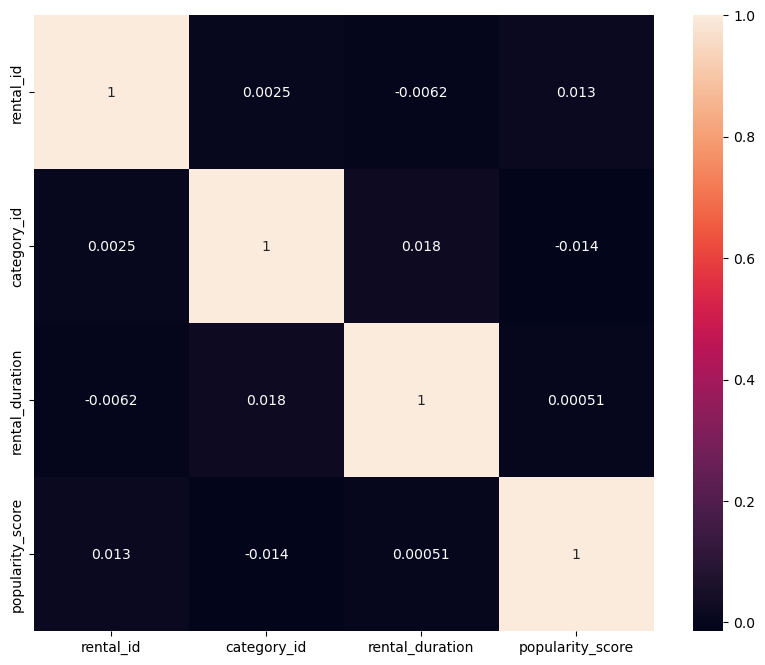

In [11]:
corr_matrix=data.corr(method='pearson')  # default
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

*I don't see any high correlation between the columns.*

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


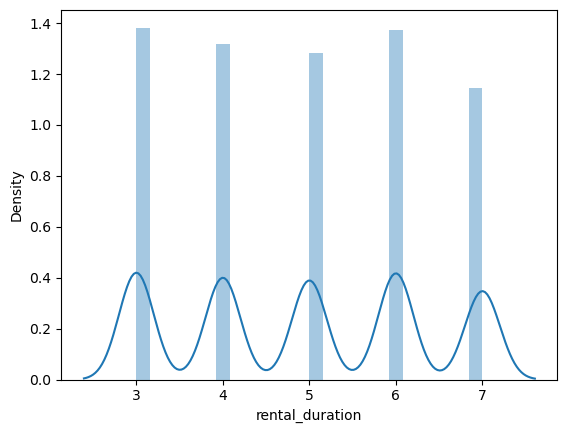

In [12]:
sns.distplot(data['rental_duration'])
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


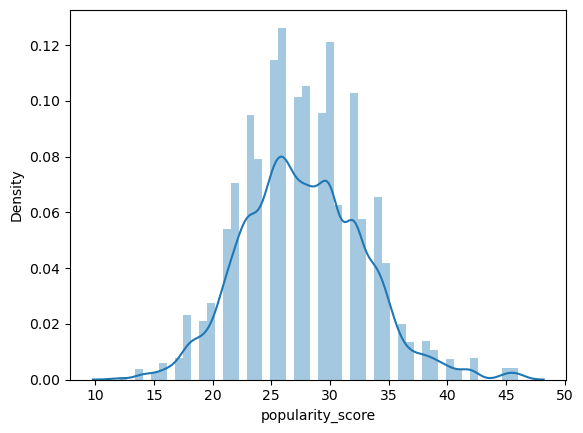

In [13]:
sns.distplot(data['popularity_score'])
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


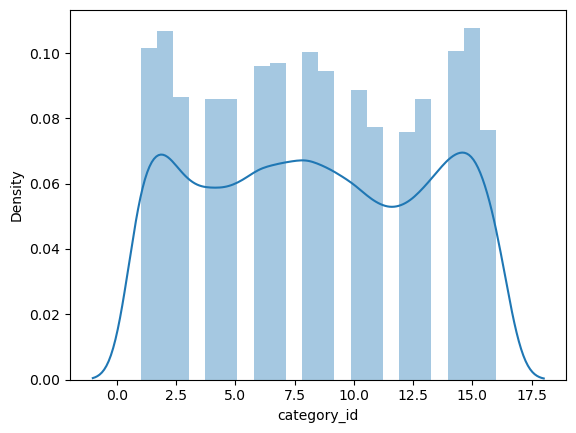

In [14]:
sns.distplot(data['category_id'])
plt.show()

In [15]:
#Creating a dataframe including the target column (IF a movie has been rented last month)
query = '''SELECT rental_id,category_id, special_features, title, rental_date, rental_duration, return_date, COUNT(rental_id) OVER (Partition by customer_id) popularity_score, IF(return_date between '2005-09-01' and '2005-09-30', "YES", "NO") AS 'rented_last_month'
FROM rental r
JOIN inventory i
USING(inventory_id)
JOIN film f
USING(film_id)
JOIN film_category
USING(film_id)
;'''

data2 = pd.read_sql_query(query, engine)
data2.head()

,rental_id,category_id,special_features,title,rental_date,rental_duration,return_date,popularity_score,rented_last_month
0,4611,15,"Commentaries,Deleted Scenes",SATURDAY LAMBS,2005-07-08 07:33:56,3,2005-07-12 13:25:56,32,NO
1,2363,7,"Commentaries,Deleted Scenes,Behind the Scenes",SAVANNAH TOWN,2005-06-18 13:33:59,5,2005-06-19 17:40:59,32,NO
2,5244,5,Commentaries,SNATCH SLIPPER,2005-07-09 13:24:07,6,2005-07-14 14:01:07,32,NO
3,573,15,"Commentaries,Deleted Scenes,Behind the Scenes",TALENTED HOMICIDE,2005-05-28 10:35:23,6,2005-06-03 06:32:23,32,NO
4,14762,14,"Trailers,Commentaries,Behind the Scenes",UNFORGIVEN ZOOLANDER,2005-08-21 23:33:57,7,2005-08-23 01:30:57,32,NO


# Normalizing numerical columns

In [16]:
#I have chosen the numerical features that can affect the target for normalization:
df = data2[['rental_duration', 'popularity_score','category_id']]
X = df.select_dtypes(include = np.number)

transformer = StandardScaler().fit(X)
x_normalized = transformer.transform(X)
x = pd.DataFrame(x_normalized)
x.columns = X.columns
x.head()

,rental_duration,popularity_score,category_id
0,-1.380869,0.825211,1.426927
1,0.046025,0.825211,-0.293298
2,0.759471,0.825211,-0.723354
3,0.759471,0.825211,1.426927
4,1.472918,0.825211,1.211899


# Encoding the categorical columns


In [17]:
cat = data2.select_dtypes(include = np.object)
cat = cat.drop(['rented_last_month'], axis=1) #removing the target column which is an object
categorical = pd.get_dummies(cat, columns=['special_features', 'title']) #Encoding the categorical columns

C:\Users\nkhat\AppData\Local\Temp\ipykernel_12400\3828319839.py:1: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cat = data2.select_dtypes(include = np.object)


In [18]:
categorical.head()

,special_features_Behind the Scenes,special_features_Commentaries,"special_features_Commentaries,Behind the Scenes","special_features_Commentaries,Deleted Scenes","special_features_Commentaries,Deleted Scenes,Behind the Scenes",special_features_Deleted Scenes,"special_features_Deleted Scenes,Behind the Scenes",special_features_Trailers,"special_features_Trailers,Behind the Scenes","special_features_Trailers,Commentaries",...,title_WORST BANGER,title_WRATH MILE,title_WRONG BEHAVIOR,title_WYOMING STORM,title_YENTL IDAHO,title_YOUNG LANGUAGE,title_YOUTH KICK,title_ZHIVAGO CORE,title_ZOOLANDER FICTION,title_ZORRO ARK
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Train test model

In [19]:
#Seperating the target and all other categorical an numerical columns
y = data2['rented_last_month'] # Target seperated
X = np.concatenate((x, categorical), axis=1) # Numerical and dummies from categoricals

In [20]:
#training 70% and testing 30% of the data by seperating them
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=100)

In [21]:
len(X_train)

8022

In [22]:
y_train

14365    NO
14255    NO
14826    NO
4407     NO
6703     NO
         ..
12119    NO
8039     NO
14147    NO
6936     NO
5640     NO
Name: rented_last_month, Length: 8022, dtype: object

*It seems that as the number of 'Yes' answers is very low compared to the number of 'No" answers, the models doesn't take into account 'yes' answers and I can't see any 'yes' answer in y_train. So the model is biased towards 'No' answer.*

In [23]:
# We traing the training dataset using Logistic Regression (No multiclass classification as we only have 2 unique values for target)
classification = LogisticRegression(random_state=0).fit(X_train, y_train)

# Evaluating the results

In [24]:
# We predict on the testing dataset
predictions = classification.predict(X_test)

In [25]:
pd.Series(predictions).value_counts()

NO    8022
dtype: int64

* There are no 'Yes' answers among the predictions!!*

In [26]:
y_test.value_counts()

NO     7988
YES      34
Name: rented_last_month, dtype: int64

In [27]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions)

array([[7988,    0],
       [  34,    0]], dtype=int64)

In [30]:
#Accuracy
classification.score(X_test, y_test)

0.9957616554475193

In [31]:
# Accuracy
from sklearn.metrics import accuracy_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, predictions)))


Accuracy: 1.00



* Even if the accuracy is very 1!!, this is not definitely correct! It's very high as the number of 'No' answers are very similar in the predictions and test samples! But the models doesn't take into account 'yes' answers*